# Advanced usage example
This notebook demostrates further usage of the of *python* interface of the `py-cmorlite` library. For installation and usage of the *command line interface* refer to the [README of the Gitlab Repository](https://gitlab.dkrz.de/m300765/py-cmorlite).

In this example we are going to standardise data from the Icosahedral Nonhydrostatic model (ICON) using the *CMIP6* standard. Icon output is saved on a non structured grid with multple variables per file. Hence we will have to remap the data and split the files by variables. This can be achieved by defining a custom method that will be used as a pre processor for the data standardisation. A more basic usage example using pre defined processing methods can be found in the [Basic usage example](https://nbviewer.jupyter.org/urls/gitlab.dkrz.de/m300765/py-cmorlite/-/raw/master/docs/BasicUsage.ipynb)

In [1]:
# Import all other modules we will use in this tutorial
import io
import os
from pathlib import Path
import requests
import shlex
from subprocess import run, PIPE
import sys
from tempfile import NamedTemporaryFile

import pandas as pd
import xarray as xr

In [2]:
from cmorlite import Standard as cs, run_cmd

We will the register our defined function using the `register` method. This will register the defined function as a pre processing method of the `Standartisation` class.

In [3]:
print(cs.register.__doc__)

Register a given method as the new processing method.

        Parameters:
            method : py-func
                The method that is registered to be the new processing method
                Note: that this method must take an input file, output file
                and a pandas variable file as argument. It also must return
                the new (cmor) variable name
            **fiexed_kwargs:
                Define keyword arguments that will be passed to the registered
                function
        


Let's define the method that remaps the input data and splits the files by variables using cdo. It is important to take two constraints into account when defining the a procsessing function:

1. The input arguments have to be: `inputfile`, `output_dir`, `variable_table`
2. The return value has te be a list of tuples of the form `[(variableName_1, outputFile_1),..., (variableName_N, outputFile_N)]`

Additional arguments that the function might need should be passed through the `fixed_kwargs` keyword arguments when registering the function. 

Let's walk through the example. We will define the remapping and splitting function first:

In [4]:
def remap_and_split(infile, outdir, variable_table, weight_file=None, target_griddes=None, gridfile=None):
    """Remap icon data and split the output by variables.
    
    This function gets one input file with an arbitrary amount of variables, applies a distance
    weighted remapping and splits the remapped file by variable.
    
    Parameters:
    ===========
    
        infile : str, pathlib.Path
            Path of the input file that will be processed
        outdir : str, pathlib.Path
            Directory where the output file well be stored to
        weight_file : str, pathlib.Path
            Path to the file containing the distance files
        target_griddes : str, pathlib.Path
            Path to the file containing the target grid describtion
        gridfile : str, pathlib.Path
            Path to the file containing the grid describtion
        
    Returns:
    ========
        list: list of tuples with variable names and filenames
    """
    outdir = Path(outdir)
    remap_cmd = f'cdo -f nc4 remap,{target_griddes},{weight_file} -setgrid,{gridfile} {infile} {outdir / "temp_file.nc"}'
    run_cmd(remap_cmd)
    split_cmd = f'cdo -f nc4 --cmor splitvar {outdir / "temp_file.nc"} {outdir / "temp_file_"}'
    run_cmd(split_cmd)
    output = [ ]
    for file in outdir.rglob('temp_file_*.nc'):
        res = run_cmd(f'cdo showvar {file}')
        variable = res.stdout.decode().strip().split(' ')[0]
        new_file = file.with_suffix('.nc4')
        cmorname = variable_table.loc[variable_table.name == variable]['cmorname'].values[0]
        _ = run_cmd(f'cdo chname,{variable},{cmorname} {file} {new_file}')
        output.append((cmorname, new_file))
    return output

First define the target `lon` `lat` describtion and save it to a temporary file

In [5]:
# Define the grid describtion
griddes = '''#
# gridID 1
#
gridtype  = lonlat
gridsize  = 64800
xsize     = 360
ysize     = 180
xname     = lon
xlongname = "longitude"
xunits    = "degrees_east"
yname     = lat
ylongname = "latitude"
yunits    = "degrees_north"
xfirst    = -179.5
xinc      = 1
yfirst    = -89.5
yinc      = 1
'''
# Write the grid description to a temporary file
griddes_file = NamedTemporaryFile(dir=cs.scratch, prefix='griddes_', suffix='.txt').name
with Path(griddes_file).open('w') as f: f.write(griddes)

In [6]:
grid_file = Path(cs.__file__).parent / 'tests' / 'icon_data' / 'icon_grid.nc'
# Generate the weights file
input_file = Path(cs.__file__).parent / 'tests' / 'icon_data' / 'icon_input.nc'
weight_file = Path('weights.nc').absolute()
gendis_cmd = f'cdo -O gendis,{griddes_file} -setgrid,{grid_file} {input_file} {weight_file}'
res = run_cmd(gendis_cmd)

In [7]:
var_lookup = """
,name,cmorname,long_name,units
1,clt,clt,total cloud cover,[m2 m-2]
52,pr,pr,precipitation flux,[kg m-2 s-1]
"""
with NamedTemporaryFile(suffix='.csv') as tf:
    with open(tf.name, 'w') as f:
        f.write(var_lookup)
    df = pd.read_csv(tf.name, index_col=0)
df

name cmorname           long_name         units
1   clt      clt   total cloud cover      [m2 m-2]
52   pr       pr  precipitation flux  [kg m-2 s-1]

Now that we have all information let's create the cmor standardisation method and register our `remap_and_split` method

In [8]:
input_directory = Path(cs.__file__).parent / 'tests' / 'icon_data*'
metafile = Path(cs.__file__).parent / 'tests' / 'global-r02b04-evalutation-icon_example.json'
CMOR = cs(metafile, input_directory, file_type='.nc', glob_pattern='*input',
                 overwrite=True,out_dir=cs.scratch / 'test', var_table=df)
CMOR.register(remap_and_split, weight_file=weight_file, target_griddes=griddes_file, gridfile=grid_file)

In [9]:
res = CMOR.run(CMOR.files)
res

[PosixPath('/scratch/k/k204230/test/cmip6/cmip6/cmpi/MPI-M/ICON-AES/amip/6hr/atmos/r1i1p1/6hr/clt/gn/v20210105/clt_6hr_ICON-AES_amip_r1i1p1_gn_202002290029-202002290029.nc'),
 PosixPath('/scratch/k/k204230/test/cmip6/cmip6/cmpi/MPI-M/ICON-AES/amip/6hr/atmos/r1i1p1/6hr/pr/gn/v20210105/pr_6hr_ICON-AES_amip_r1i1p1_gn_202002290029-202002290029.nc')]

In [10]:
#Sanity check
dset = xr.open_mfdataset(res, combine='by_coords', parallel=True)
dset

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 180, lon: 360, time: 1)
Coordinates:
  * time      (time) datetime64[ns] 2020-02-29
  * lon       (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: bnds
Data variables:
    lon_bnds  (lon, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
    clt       (time, lat, lon) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    pr        (time, lat, lon) float32 dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes:
    CDI:                    Climate Data Interface version 1.9.9 (https://mpi...
    Conventions:            CF-1.7
    source:                 git@gitlab.dkrz.de:icon/icon-aes.git@6b5726d38970...
    history:                Wed Jan 06 16:34:56 2021: cdo -O -s -f nc4 -z zip...
    references:             see MPIM/DWD publications
    comment:                Sapphire Dyamond (k203123) on m11345 (Linux 2.6.3...
    tracking_id:            0c3441eb-c25c-570d-a8ce-cd00e2960f0a
    creation_date:          2021-01-06T16:34:56Z
    CDO:                    Climate Data Operators version 1.9.9 (https://mpi...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    title:                  ICON-AES output prepared for CMIP6
    activity_id:            cmpi
    contact:                test@mpimet.mpg.de
    experiment_id:          amip
    forcing_index:          1
    frequency:              sampled every 6 hours
    further_info_url:       http://www.remo-rcm.de/
    grid_label:             gn
    grid:                   data reported on a model's native grid
    institution_id:         MPI-M
    initialization_index:   1
    parent_mip_era:         CMIP6
    nominal_resolution:     100 km
    parent_activity_id:     CMIP6
    parent_experiment_id:   cmpi
    parent_variant_label:   r1i1p1
    product:                cmpi
    project_id:             CMIP6
    realization_index:      1
    realm:                  atmos
    source_id:              ICON-AES
    source_type:            AGCM
    table_id:               6hr
    variant_label:          r1i1p1
    cmor_version:           2.9.1
    initialization_method:  1
    physics_version:        1

The standartisation also applies vairalbe conversion using the `pint` library. Let's check if the accumulated total cloud cover field [*frac.*] was converted correctly percents [*%*] by plotting the data field:

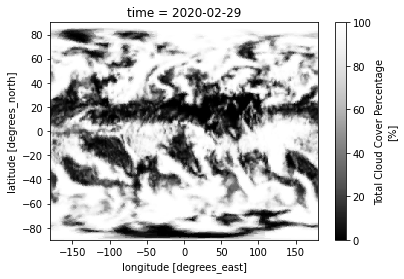

In [11]:
_ = dset['clt'].isel(time=0).plot(cmap='Greys_r')